In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as skmts
import sklearn.preprocessing as skpre
import scipy.stats as scistat
import glob
import pickle
import statsmodels.stats.multitest as multi
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def get_perTriplet_performance(data_path):
    """return overall performance across folds
    :param data_path: path to model_prediction.txt
    """
    # collect files
    df_list = []
    for f in glob.glob(data_path+'*.model_prediction.txt'):
        df = pd.read_csv(f, header=0, sep="\t")
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    
    # get triplet from icombo
    df[['did_row', 'did_col', 'cid', 'conc_r', 'conc_c']]= df['icombo'].str.split('=', expand=True)
    df['triplet'] = df['did_row'] + '_' + df['did_col'] + '_' + df['cid']
   
    
    # collect qualified triplets: have positives and negatives  
    g = df.groupby(by=['triplet'])['synergy_label'].agg('mean').to_frame('#label')
    all_pos = g[g['#label']==1].index.tolist()
    all_neg = g[g['#label']==0].index.tolist()
    triplet_list = sorted(set(g.index) - set(all_pos+all_neg))
    
    # get per-triplet performance
    record_list = [] # (N, AUC, AUPRC)
    grps = df.groupby(['triplet'])
    for triplet in triplet_list:
        sample = grps.get_group(triplet)
        auc = skmts.roc_auc_score(sample['synergy_label'], sample['predicted_synergy'])
        auprc = skmts.average_precision_score(sample['synergy_label'], sample['predicted_synergy'])
        record_list.append( (len(sample), auc, auprc) )
    df = pd.DataFrame.from_records(record_list, index=triplet_list, columns=['N', 'AUC', 'AUPRC'])
    df = df.sort_values(by=['N', 'AUPRC', 'AUC'], ascending=False)
    print(f'Top 10 triplet:\n{df.head(10)}')
    
    # calculate mean , standard deviation
    print(f'per-triplet performance')
    print(pd.concat([df.mean(axis=0).to_frame(name='mean'), df.std(axis=0).to_frame(name='standard deviation')], axis=1))
    
    return df

In [3]:
cv_path = '../data/cv_data/ONEIL/classification/random_split/test/'
input_path = '../data/input_data/EXP/c2/transform_ssGSEA/'
output_path = '../classification/random_split/EXP/c2/DRUG_CELL_DDSE/transform_ssGSEA/'
kfold = 10

In [4]:
cv_dict = {} # cv_str: fname
pred_dict = {} # cv_str: fname
emb_dict = {}
for k in range(0, kfold):
    cv_str = 'cv_' + str(k)
    for f in glob.glob(cv_path+'*.data.pkl'):
        if cv_str in f:
            cv_dict[cv_str] = f
            
    for f in glob.glob(output_path+'*.model_prediction.txt'):
        if cv_str in f:
            pred_dict[cv_str] = f
            
    for f in glob.glob(output_path+'*.subgraph_embeddings_attentionweights.pkl'):
        if cv_str in f:
            emb_dict[cv_str] = f
            
print(f'kfold={kfold}: cv files={len(cv_dict)} | embedding files={len(emb_dict)} | prediction files={len(pred_dict)}')

kfold=10: cv files=10 | embedding files=10 | prediction files=10


In [5]:
dose_df = pd.read_pickle(input_path+'dose_subgraph.pkl').T # icombo by geneset
chem_df = pd.read_pickle(input_path+'chemical_subgraph.pkl').T # icombo by kmer, geneset

cv_list = []
pred_list = []
cell_attn_list = []
target_attn_list = []
kmer_attn_list = []
for k in range(0, kfold):
    cv_str = 'cv_' + str(k)
    
    # load data
    cv_df = pd.read_pickle(cv_dict[cv_str])
    pred_df = pd.read_csv(pred_dict[cv_str], header=0, sep="\t")
    with open(emb_dict[cv_str], 'rb') as fin:
        subg_dict = pickle.load(fin)
        
        # dose
        #dose_emb = emb_dict['dose'][0]
        dose_attn = pd.DataFrame(subg_dict['dose'][1], 
                                 index=cv_df['icombo'], columns=dose_df.columns)
    
        # chemical
        #chemical_emb = emb_dict['chemical'][0]
        chemical_attn = pd.DataFrame(subg_dict['chemical'][1],
                                     index=cv_df['icombo'], columns=chem_df.columns)
        
        g_list = [col for col in chemical_attn.columns if 'GENES' in col]
        k_list = sorted( set(chem_df.columns)-set(g_list) )
        target_attn = chemical_attn[g_list]
        kmer_attn = chemical_attn[k_list]
        
    # append to list
    cv_list.append(cv_df)
    pred_list.append(pred_df)
    cell_attn_list.append(dose_attn)
    kmer_attn_list.append(kmer_attn)
    target_attn_list.append(target_attn)

# merge all
cv_df = pd.concat(cv_list, axis=0)
pred_df = pd.concat(pred_list, axis=0)
cell_df = pd.concat(cell_attn_list, axis=0)
target_df = pd.concat(target_attn_list, axis=0)
kmer_df = pd.concat(kmer_attn_list, axis=0)
print(f'cv_df={cv_df.shape}: attention weight: cell={cell_df.shape} | target={target_df.shape} | kmer={kmer_df.shape}')

cv_df=(60770, 12): attention weight: cell=(60770, 506) | target=(60770, 13) | kmer=(60770, 9884)


In [6]:
weighted_subg_dict = {'cell':None, 'target':None, 'kmer':None}

scaler = skpre.MinMaxScaler().set_output(transform="pandas").fit(dose_df)
dose_df = scaler.transform(dose_df)
scaler = skpre.MinMaxScaler().set_output(transform="pandas").fit(chem_df)
chem_df = scaler.transform(chem_df)


icombo = sorted(set(cell_df.index) & set(dose_df.index))
dose_subg = dose_df.loc[icombo]
chem_subg = chem_df.loc[icombo]

g_list = [col for col in chem_subg.columns if 'GENES' in col]
k_list = sorted( set(chem_subg.columns)-set(g_list) )
target_subg = chem_subg[g_list]
kmer_subg = chem_subg[k_list]


weighted_cell_df = (dose_subg * cell_df).replace({-0:0})
weighted_target_df = (target_subg * target_df).replace({-0:0})
weighted_kmer_df = (kmer_subg * kmer_df).replace({-0:0})

weighted_cell_df = weighted_cell_df.loc[:, (weighted_cell_df!=0).any(axis=0)]
weighted_target_df = weighted_target_df.loc[:, (weighted_target_df!=0).any(axis=0)]
weighted_kmer_df = weighted_kmer_df.loc[:, (weighted_kmer_df!=0).any(axis=0)]

g_list = sorted( set(weighted_cell_df.columns)&set(weighted_target_df.columns) )
weighted_cell_df = weighted_cell_df[g_list]
weighted_target_df = weighted_target_df[g_list]

weighted_subg_dict['cell'] = weighted_cell_df
weighted_subg_dict['target'] = weighted_target_df
weighted_subg_dict['kmer'] = weighted_kmer_df
print(f'weighted subgraphs: cell={weighted_cell_df.shape} | target={weighted_target_df.shape} | kmer={weighted_kmer_df.shape}')

weighted subgraphs: cell=(60770, 13) | target=(60770, 13) | kmer=(60770, 2154)


# C2: Pathways

In [7]:
top_triplet_df = get_perTriplet_performance(output_path)

Top 10 triplet:
                           N       AUC     AUPRC
did_1730_did_206_cid_122  27  0.346154  0.962981
did_1730_did_206_cid_6    24  0.347826  0.958827
did_1730_did_206_cid_9    22  0.807018  0.966934
did_1730_did_966_cid_122  20  0.789474  0.988578
did_1117_did_180_cid_123  18  0.987500  0.990909
did_908_did_657_cid_123   18  0.964286  0.990136
did_1815_did_206_cid_65   18  0.531250  0.934346
did_1730_did_206_cid_132  18  0.176471  0.916954
did_908_did_966_cid_39    17  0.625000  0.973770
did_1815_did_206_cid_6    17  0.450000  0.736308
per-triplet performance
           mean  standard deviation
N      5.465076            2.825249
AUC    0.668209            0.370737
AUPRC  0.808919            0.238037


In [8]:
cv_df[['did_row', 'did_col', 'cid', 'conc_r', 'conc_c']]= cv_df['icombo'].str.split('=', expand=True)
cv_df['itriplet'] = cv_df['did_row'] + '_' + cv_df['did_col'] + '_' + cv_df['cid']
cv_df.head()

,triplet,icombo,ipair,cid,synergy_label,region_label,tcga_id,tissue_id,dose_region,tcga abbrev,tissue_name,synergy_loewe,did_row,did_col,conc_r,conc_c,itriplet
0,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.0011=c0.0004,did_122-did_180,cid_7,1,2,1,1,low,TCGA_OV,ovary,11.364638,did_122,did_180,r0.0011,c0.0004,did_122_did_180_cid_7
1,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.005=c0.0004,did_122-did_180,cid_7,1,2,1,1,low,TCGA_OV,ovary,12.960303,did_122,did_180,r0.005,c0.0004,did_122_did_180_cid_7
2,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.0223=c0.0004,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,19.030175,did_122,did_180,r0.0223,c0.0004,did_122_did_180_cid_7
3,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.1=c0.000115,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,16.017177,did_122,did_180,r0.1,c0.000115,did_122_did_180_cid_7
4,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.1=c0.0004,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,23.225788,did_122,did_180,r0.1,c0.0004,did_122_did_180_cid_7


## per-triplet Mann-Witney U test

In [9]:
record_list = [] # triplet, n, geneset, p1, p2



g_list = weighted_subg_dict['cell'].columns.tolist()
for itriplet in top_triplet_df.head(n=20).index.tolist():
    syn_icombo = cv_df[(cv_df['itriplet']==itriplet) & (cv_df['synergy_loewe']>10)]['icombo'].values.tolist()
    ant_icombo = cv_df[(cv_df['itriplet']==itriplet) & (cv_df['synergy_loewe']<-10)]['icombo'].values.tolist()
    n = len(syn_icombo)+len(ant_icombo)
    
    if len(syn_icombo) > 1 and len(ant_icombo) > 1:
        print(f'itriplet={itriplet}: N={len(syn_icombo)} (syn) + {len(ant_icombo)} (ant)')
    
        for g in g_list:
            # perform welth t test
            alpha = 0.05
            t1, p1 = scistat.mannwhitneyu(weighted_subg_dict['cell'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['cell'].loc[ant_icombo,g].values)
            t2, p2 = scistat.mannwhitneyu(weighted_subg_dict['target'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['target'].loc[ant_icombo,g].values)
            if p1 <= alpha and p2 <= alpha:
                #print(f'    g={g}: p1={p1}|p2={p2}')
                record_list.append( (itriplet, n, g, p1, p2) )
# merge to datafrae
per_triplet_ttest_df = pd.DataFrame.from_records(record_list, columns=['itriplet', 'N', 'Geneset', 'p-value (cell)', 'p-value (target)'])

# adjust p value
_, adj1, _, _ = multi.multipletests(per_triplet_ttest_df['p-value (cell)'].values, alpha=0.05, method='fdr_bh')
_, adj2, _, _ = multi.multipletests(per_triplet_ttest_df['p-value (target)'].values, alpha=0.05, method='fdr_bh')
per_triplet_ttest_df['adj.p-value(cell)'] = adj1
per_triplet_ttest_df['adj.p-value(target)'] = adj2
per_triplet_ttest_df

itriplet=did_1730_did_206_cid_9: N=19 (syn) + 3 (ant)
itriplet=did_1117_did_180_cid_123: N=10 (syn) + 8 (ant)
itriplet=did_908_did_657_cid_123: N=14 (syn) + 4 (ant)
itriplet=did_1815_did_206_cid_65: N=16 (syn) + 2 (ant)
itriplet=did_1815_did_206_cid_6: N=12 (syn) + 5 (ant)
itriplet=did_1671_did_1386_cid_186: N=8 (syn) + 8 (ant)
itriplet=did_574_did_1386_cid_186: N=8 (syn) + 8 (ant)
itriplet=did_720_did_1500_cid_98: N=13 (syn) + 3 (ant)
itriplet=did_147_did_922_cid_98: N=2 (syn) + 13 (ant)


,itriplet,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1815_did_206_cid_6,17,REACTOME_TP53_REGULATES_METABOLIC_GENES,0.013575,0.020530,0.038095,0.043872
1,did_147_did_922_cid_98,15,KEGG_MELANOGENESIS,0.038095,0.019048,0.038095,0.043872
2,did_147_did_922_cid_98,15,REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTI...,0.038095,0.043872,0.038095,0.043872
3,did_147_did_922_cid_98,15,REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_H...,0.038095,0.043872,0.038095,0.043872
4,did_147_did_922_cid_98,15,REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED...,0.038095,0.038095,0.038095,0.043872
5,did_147_did_922_cid_98,15,REACTOME_MITOCHONDRIAL_BIOGENESIS,0.038095,0.043872,0.038095,0.043872
6,did_147_did_922_cid_98,15,REACTOME_RUNX1_REGULATES_GENES_INVOLVED_IN_MEG...,0.038095,0.043872,0.038095,0.043872
7,did_147_did_922_cid_98,15,REACTOME_RUNX1_REGULATES_TRANSCRIPTION_OF_GENE...,0.038095,0.043872,0.038095,0.043872
8,did_147_did_922_cid_98,15,REACTOME_TP53_REGULATES_METABOLIC_GENES,0.038095,0.019048,0.038095,0.043872
9,did_147_did_922_cid_98,15,WP_ADIPOGENESIS,0.038095,0.043872,0.038095,0.043872


## Per-pair Mann Witney U test

In [10]:
record_list = [] # pair, tissue, n, geneset, p1, p2



g_list = weighted_subg_dict['cell'].columns.tolist()
for itriplet in top_triplet_df.head(n=20).index.tolist():
    
    ipair = cv_df[cv_df['itriplet']==itriplet]['ipair'].values[0]
    tissue_list = sorted(cv_df[cv_df['ipair']==ipair]['tissue_name'].unique())
    for tissue in tissue_list:
        syn_icombo = cv_df[(cv_df['tissue_name']==tissue) & (cv_df['synergy_loewe']>10)]['icombo'].values.tolist()
        ant_icombo = cv_df[(cv_df['tissue_name']==tissue) & (cv_df['synergy_loewe']<-10)]['icombo'].values.tolist()  
        n = len(syn_icombo) + len(ant_icombo)
    
        if len(syn_icombo) > 1 and len(ant_icombo) > 1:
            print(f'itriplet={itriplet}: tissue={tissue} N={len(syn_icombo)} (syn) + {len(syn_icombo)} (syn other)')
    
            for g in g_list:
                # perform welth t test
                alpha = 0.05
                t1, p1 = scistat.mannwhitneyu(weighted_subg_dict['cell'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['cell'].loc[ant_icombo,g].values)
                t2, p2 = scistat.mannwhitneyu(weighted_subg_dict['target'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['target'].loc[ant_icombo,g].values)
                if p1 <= alpha and p2 <= alpha:
                    #print(f'    g={g}: p1={p1}|p2={p2}')
                    record_list.append( (ipair, tissue, n, g, p1, p2) )
                    
        
# merge to datafrae
per_tissue_ttest_df = pd.DataFrame.from_records(record_list, columns=['ipair', 'tissue', 'N', 'Geneset', 'p-value (cell)', 'p-value (target)'])

# adjust p value
_, adj1, _, _ = multi.multipletests(per_tissue_ttest_df['p-value (cell)'].values, alpha=0.05, method='fdr_bh')
_, adj2, _, _ = multi.multipletests(per_tissue_ttest_df['p-value (target)'].values, alpha=0.05, method='fdr_bh')
per_tissue_ttest_df['adj.p-value(cell)'] = adj1
per_tissue_ttest_df['adj.p-value(target)'] = adj2
per_tissue_ttest_df

itriplet=did_1730_did_206_cid_122: tissue=breast N=5199 (syn) + 5199 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=large_intestine N=9234 (syn) + 9234 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=lung N=9886 (syn) + 9886 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=ovary N=10787 (syn) + 10787 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=prostate N=1299 (syn) + 1299 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=skin N=8430 (syn) + 8430 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=breast N=5199 (syn) + 5199 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=large_intestine N=9234 (syn) + 9234 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=lung N=9886 (syn) + 9886 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=ovary N=10787 (syn) + 10787 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=prostate N=1299 (syn) + 1299 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=skin N=8430 (syn) + 8430 (syn other)
itriplet=did_1730_did_20

itriplet=did_1117_did_206_cid_6: tissue=breast N=5199 (syn) + 5199 (syn other)
itriplet=did_1117_did_206_cid_6: tissue=large_intestine N=9234 (syn) + 9234 (syn other)
itriplet=did_1117_did_206_cid_6: tissue=lung N=9886 (syn) + 9886 (syn other)
itriplet=did_1117_did_206_cid_6: tissue=ovary N=10787 (syn) + 10787 (syn other)
itriplet=did_1117_did_206_cid_6: tissue=prostate N=1299 (syn) + 1299 (syn other)
itriplet=did_1117_did_206_cid_6: tissue=skin N=8430 (syn) + 8430 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=breast N=5199 (syn) + 5199 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=large_intestine N=9234 (syn) + 9234 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=lung N=9886 (syn) + 9886 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=ovary N=10787 (syn) + 10787 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=prostate N=1299 (syn) + 1299 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=skin N=8430 (syn) + 8430 (syn other)
itriplet=did_1730_did_966_cid_

,ipair,tissue,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1730-did_206,breast,8155,KEGG_MELANOGENESIS,0.006487,5.318472e-03,0.011192,6.972642e-03
1,did_1730-did_206,large_intestine,12965,REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTI...,0.000783,4.238676e-02,0.001905,4.238676e-02
2,did_1730-did_206,large_intestine,12965,REACTOME_RUNX1_REGULATES_TRANSCRIPTION_OF_GENE...,0.028718,1.472611e-03,0.035029,2.095638e-03
3,did_1730-did_206,lung,14218,REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED...,0.027550,3.453385e-02,0.035029,3.674048e-02
4,did_1730-did_206,lung,14218,REACTOME_HEDGEHOG_LIGAND_BIOGENESIS,0.042596,5.123849e-08,0.042596,2.891935e-07
...,...,...,...,...,...,...,...,...
328,did_1730-did_966,prostate,1614,REACTOME_RNA_POLYMERASE_II_TRANSCRIBES_SNRNA_G...,0.000875,2.775258e-04,0.001905,5.250914e-04
329,did_1730-did_966,prostate,1614,REACTOME_RUNX1_REGULATES_GENES_INVOLVED_IN_MEG...,0.000606,1.221598e-02,0.001905,1.490081e-02
330,did_1730-did_966,prostate,1614,REACTOME_TP53_REGULATES_METABOLIC_GENES,0.000874,9.995839e-04,0.001905,1.555427e-03
331,did_1730-did_966,prostate,1614,WP_ADIPOGENESIS,0.000709,1.636646e-06,0.001905,6.987219e-06


In [23]:
per_triplet_ttest_df.head()

,itriplet,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1815_did_206_cid_6,17,REACTOME_TP53_REGULATES_METABOLIC_GENES,0.013575,0.020530,0.038095,0.043872
1,did_147_did_922_cid_98,15,KEGG_MELANOGENESIS,0.038095,0.019048,0.038095,0.043872
2,did_147_did_922_cid_98,15,REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTI...,0.038095,0.043872,0.038095,0.043872
3,did_147_did_922_cid_98,15,REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_H...,0.038095,0.043872,0.038095,0.043872
4,did_147_did_922_cid_98,15,REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED...,0.038095,0.038095,0.038095,0.043872


In [24]:
per_tissue_ttest_df.head()

,ipair,tissue,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1730-did_206,breast,8155,KEGG_MELANOGENESIS,0.006487,5.318472e-03,0.011192,6.972642e-03
1,did_1730-did_206,large_intestine,12965,REACTOME_ACTIVATED_PKN1_STIMULATES_TRANSCRIPTI...,0.000783,4.238676e-02,0.001905,4.238676e-02
2,did_1730-did_206,large_intestine,12965,REACTOME_RUNX1_REGULATES_TRANSCRIPTION_OF_GENE...,0.028718,1.472611e-03,0.035029,2.095638e-03
3,did_1730-did_206,lung,14218,REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED...,0.027550,3.453385e-02,0.035029,3.674048e-02
4,did_1730-did_206,lung,14218,REACTOME_HEDGEHOG_LIGAND_BIOGENESIS,0.042596,5.123849e-08,0.042596,2.891935e-07


In [31]:
anno_df = cv_df[['triplet', 'itriplet', 'icombo', 'ipair', 'cid']]
anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)
itriplet_triplet_dict = dict(zip(anno_df['itriplet'], anno_df['triplet']))
ipair_pair_dict = dict( zip(anno_df['ipair'], anno_df['pair']) )
anno_df.head()

/tmp/ipykernel_3676533/1473336640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)
/tmp/ipykernel_3676533/1473336640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)


,triplet,itriplet,icombo,ipair,cid,pair,cell_line_name
0,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.0011=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
1,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.005=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
2,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.0223=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
3,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.1=c0.000115,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
4,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.1=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780


In [32]:
per_triplet_ttest_df['triplet'] = per_triplet_ttest_df['itriplet'].replace(itriplet_triplet_dict)
per_tissue_ttest_df['pair'] = per_tissue_ttest_df['ipair'].replace(ipair_pair_dict)

In [33]:
# save to file

per_triplet_ttest_df.to_csv('C2.per_triplet_WeightAttentionAnalysis.txt', header=True, index=False, sep="\t")
per_tissue_ttest_df.to_csv('C2.per_triplet_tissue_WeightAttentionAnalysis.txt', header=True, index=False, sep="\t")

# cell line-specific & tissue-specific

In [12]:
itriplet_ipair_dict = dict(zip(cv_df['itriplet'], cv_df['ipair']))
itriplet_tissue_dict = dict(zip(cv_df['itriplet'], cv_df['tissue_name']))
triplet_grps = per_triplet_ttest_df.groupby(['itriplet'])
pair_grps = per_tissue_ttest_df.groupby(['ipair'])
for itriplet in triplet_grps.groups.keys():
    ipair = itriplet_ipair_dict[itriplet]
    tissue = itriplet_tissue_dict[itriplet]
    
    # get cell line's important genesets
    cell_df = triplet_grps.get_group(itriplet)
    cell_g_list = cell_df[cell_df['adj.p-value(cell)']<=0.05]['Geneset'].values.tolist()
    #print(cell_g_list)
    # get tissue's important genesets
    ipair = itriplet_ipair_dict[itriplet]
    ipair_df = pair_grps.get_group(ipair)
    ipair_df = ipair_df[(ipair_df['tissue']==tissue)&(ipair_df['adj.p-value(cell)']<=0.05)]
    if len(ipair_df) > 0:
        tissue_g_list = ipair_df['Geneset'].values.tolist()
        #print(tissue_g_list)
        shared_list = sorted( set(cell_g_list)&set(tissue_g_list) )
        print(f'itriplet={itriplet}: ipair={ipair}: tissue={tissue} | cell-specific genes={len(cell_g_list)} | tissue-specific genes={len(tissue_g_list)}')
        print(f'shared:{shared_list}\n')


itriplet=did_147_did_922_cid_98: ipair=did_147-did_922: tissue=lung | cell-specific genes=10 | tissue-specific genes=5
shared:['REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES', 'WP_THERMOGENESIS']



In [13]:
df = pd.read_pickle('../data/processed_data/drugcomb_processed_data.pkl')
itriplet = 'did_147_did_922_cid_98'
ipair = itriplet_ipair_dict[itriplet]
cid = 'cid_98'
df[(df['ipair']==ipair) & (df['cid']==cid)][['drug_row', 'drug_col', 'cell_line_name', 'drug_row_clinical_phase','drug_col_clinical_phase',]]

,drug_row,drug_col,cell_line_name,drug_row_clinical_phase,drug_col_clinical_phase
0,5-Fluorouracil,Lapatinib,MSTO,4,4
1,5-Fluorouracil,Lapatinib,MSTO,4,4
2,5-Fluorouracil,Lapatinib,MSTO,4,4
3,5-Fluorouracil,Lapatinib,MSTO,4,4
4,5-Fluorouracil,Lapatinib,MSTO,4,4
5,5-Fluorouracil,Lapatinib,MSTO,4,4
6,5-Fluorouracil,Lapatinib,MSTO,4,4
7,5-Fluorouracil,Lapatinib,MSTO,4,4
8,5-Fluorouracil,Lapatinib,MSTO,4,4
9,5-Fluorouracil,Lapatinib,MSTO,4,4


# Visualize

In [14]:
itriplet = 'did_147_did_922_cid_98'
g_list = ['REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES', 'WP_THERMOGENESIS']

icombo_list = cv_df[cv_df['itriplet']==itriplet]['icombo'].values.tolist()

In [15]:
cell = weighted_subg_dict['cell'].loc[icombo_list, g_list]
target = weighted_subg_dict['target'].loc[icombo_list, g_list]

In [16]:
icombo_region_dict = dict(zip(cv_df['icombo'], cv_df['dose_region']))
icombo_tissue_dict = dict(zip(cv_df['icombo'], cv_df['tissue_name']))

In [17]:
color_df = cv_df[cv_df['icombo'].isin(cell.index)][['icombo', 'synergy_label']]
color_df['synergy_label'] = color_df['synergy_label'].replace({0:'g', 1:'r'})
color_df = color_df.set_index(['icombo'])
color_df

,synergy_label
icombo,
did_147=did_922=cid_98=r0.35=c0.055,r
did_147=did_922=cid_98=r0.35=c0.245,r
did_147=did_922=cid_98=r0.35=c5.0,g
did_147=did_922=cid_98=r1.08=c0.055,g
did_147=did_922=cid_98=r1.08=c0.245,g
did_147=did_922=cid_98=r1.08=c1.1,g
did_147=did_922=cid_98=r1.08=c5.0,g
did_147=did_922=cid_98=r3.25=c0.055,g
did_147=did_922=cid_98=r3.25=c0.245,g


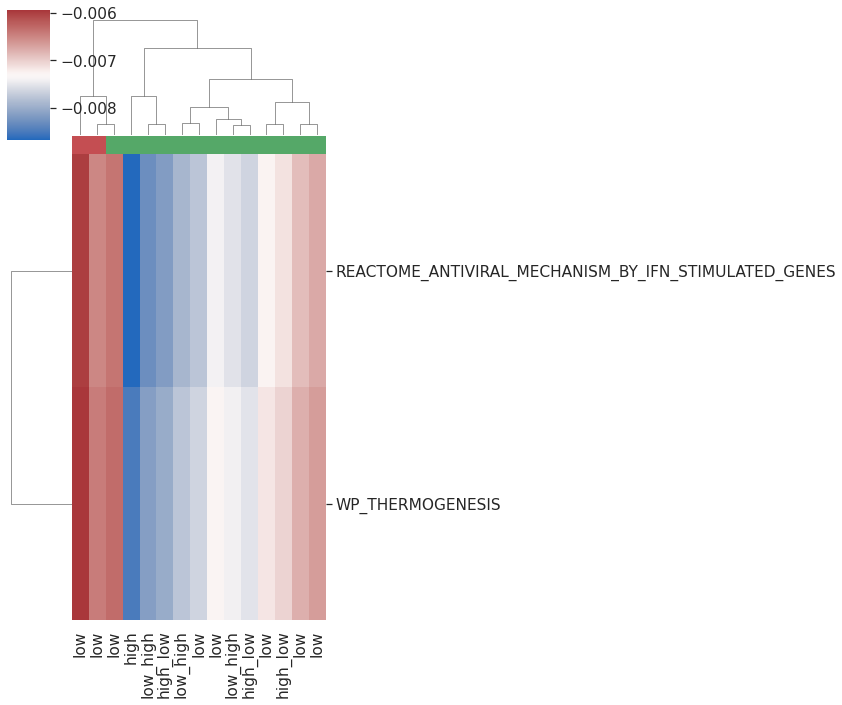

In [18]:
sns.set(font_scale=1.4)
g = sns.clustermap(cell.rename(icombo_region_dict).T, cmap='vlag', yticklabels=True, col_colors=color_df['synergy_label'].values, figsize=(12,10))
g.savefig('SAFER-C2.jpeg', dpi=300)

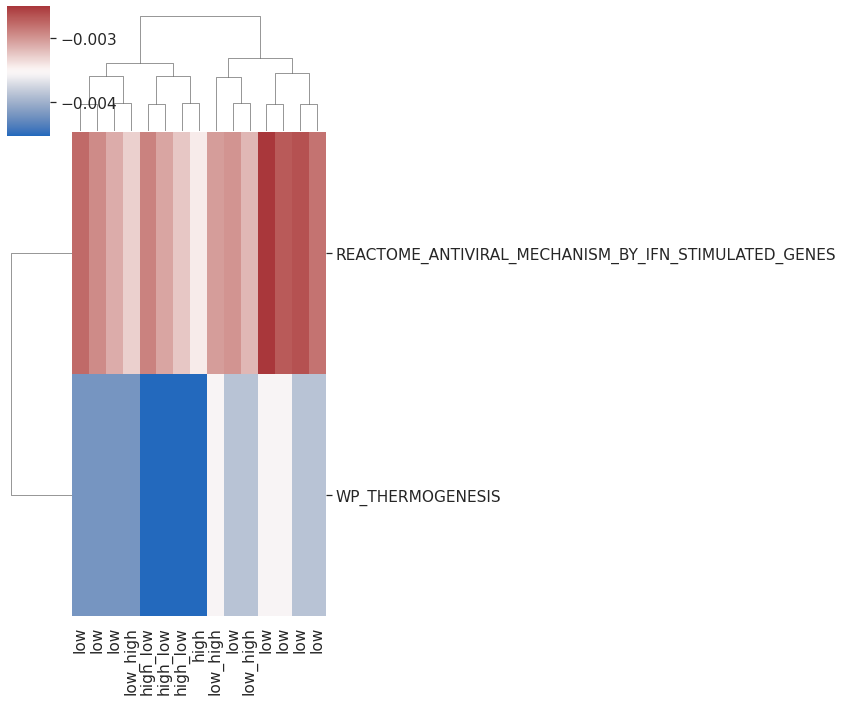

In [19]:
sns.set(font_scale=1.4)
g = sns.clustermap(target.rename(icombo_region_dict).T, cmap='vlag', yticklabels=True, figsize=(12,10))

<AxesSubplot:ylabel='Geneset'>

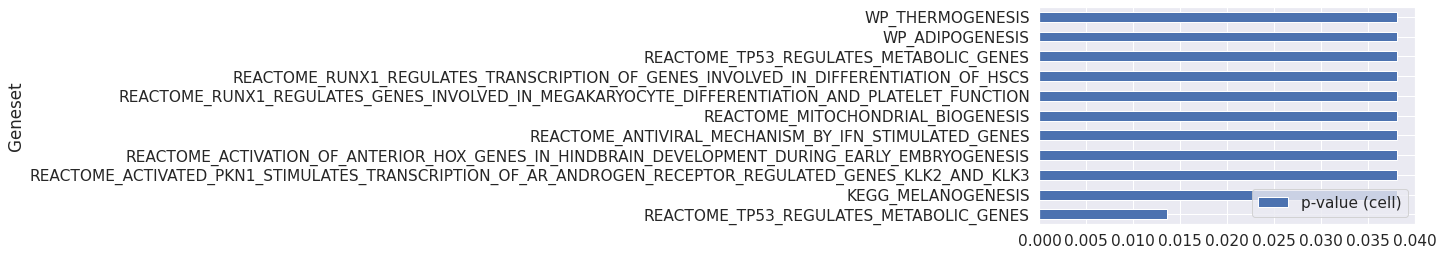

In [20]:
per_triplet_ttest_df[['Geneset', 'p-value (cell)']].set_index('Geneset').plot(kind='barh')

In [21]:
per_triplet_ttest_df.columns

Index(['itriplet', 'N', 'Geneset', 'p-value (cell)', 'p-value (target)',
       'adj.p-value(cell)', 'adj.p-value(target)'],
      dtype='object')